In [2]:
# Only run the first time

import torch
import cv2
import os

data = torch.zeros(16*2160, 24, 24)
labels = torch.zeros(16*2160, 10)

n = 0
for folder in os.listdir("Numbers/transformedNumbers"):
    for fileName in os.listdir(f"Numbers/transformedNumbers/{folder}"):
        data[n] = torch.tensor(cv2.imread(f"Numbers/transformedNumbers/{folder}/{fileName}")[:,:,1])
        labels[n, int(folder)] = 1 
        n+=1

torch.save(data, "X.pt")
torch.save(labels, "Y.pt")

KeyboardInterrupt: 

In [129]:
import torch
import os
import cv2
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda")

X = torch.load("X.pt")
y = torch.load("y.pt")

In [130]:
dim = 24

split = int(0.95*X.shape[0]) 
allIndexes = torch.randperm(X.shape[0])
trainIndexes = allIndexes[:split]
testIndexes  = allIndexes[split:]

X_train, X_test = X.view(-1, 1, dim, dim)[trainIndexes], X.view(-1, 1, dim, dim)[testIndexes]
y_train, y_test = y[trainIndexes], y[testIndexes]
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)
X_train = X_train.to(device) 
X_test = X_test.to(device) 
y_train = y_train.to(device) 
y_test = y_test.to(device) 


torch.Size([32832, 1, 24, 24]) torch.Size([1728, 1, 24, 24])
torch.Size([32832, 10]) torch.Size([1728, 10])


7859 tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], device='cuda:0')


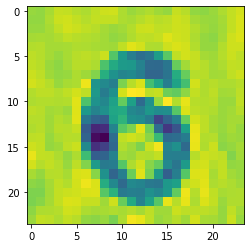

In [131]:
n = random.randint(0, 10000)
plt.imshow(X_train[n].view(dim, dim).cpu())
print(n, y_train[n])

In [69]:
import pickle


with open("params.pkl", 'rb') as f:
    params = pickle.load(f)
print([p.shape for p in params])
w1, b1, w2, b2, w3, b3, k1, k2, k3, w4, b4 = params



FileNotFoundError: [Errno 2] No such file or directory: 'params.pkl'

In [132]:


datasetSize = X_train.shape[0]
off = 0.4

if True:
    layers = [150, 150, 150, 10]
    k1 = torch.rand(32, 1, 3, 3).float().to(device) * off - off/2  #   Do not use padding -- 13x13
    k2 = torch.rand(32, 32, 3, 3).float().to(device) * off - off/2  #  Do not use padding -- 11x11
    k3 = torch.rand(8, 32, 3, 3).float().to(device) * off - off/2  #   Do not use padding -- 9x9
    w1 = torch.rand(128, layers[0]).float().to(device) * off - off/2
    b1 = torch.rand(layers[0]).float().to(device) * off - off/2
    w2 = torch.rand(layers[0], layers[1]).float().to(device) * off - off/2
    b2 = torch.rand(layers[1]).float().to(device) * off - off/2
    w3 = torch.rand(layers[1], layers[2]).float().to(device) * off - off/2
    b3 = torch.rand(layers[2]).float().to(device) * off - off/2
    w4 = torch.rand(layers[2], layers[3]).float().to(device) * off - off/2
    b4 = torch.rand(layers[3]).float().to(device) * off - off/2

    params = [w1, b1, w2, b2, w3, b3, k1, k2, k3, w4, b4]


for p in params:
    print(p.shape)
    p.requires_grad_()
    
lossi = []
losstesti = []
acctesti = []


torch.Size([128, 150])
torch.Size([150])
torch.Size([150, 150])
torch.Size([150])
torch.Size([150, 150])
torch.Size([150])
torch.Size([32, 1, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([8, 32, 3, 3])
torch.Size([150, 10])
torch.Size([10])


In [133]:
%%time
epochs = 10000
batchsize = 1000
lossf = torch.nn.MSELoss()

def forward(data):
    l = data.shape[0]
    c1 = F.conv2d(data, k1)
    c2 = F.conv2d(c1, k2)
    p1 = F.max_pool2d(c2, (2, 2))
    c3 = F.conv2d(p1, k3)
    p2 = F.max_pool2d(c3, (2, 2))
    n1 = torch.tanh(p2.view(l, -1) @ w1 + b1)
    n2 = torch.tanh(n1 @ w2 + b2)
    n3 = torch.tanh(n2 @ w3 + b3)
    out = F.softmax(n3 @ w4 + b4, 1)
    return out
    

for EPOCH in range(epochs):
    indexes = (torch.rand(batchsize)*X_train.shape[0]).long()
    
    # Forward
    out = forward(X_train[indexes])
    
    #print(out.shape)
    loss = torch.sum((out - y_train[indexes])**2)/batchsize
    loss.backward()
    lossi.append(loss.item())
    if EPOCH in [i for i in range(0, epochs, epochs//10)]: print(loss)

    # Test
    with torch.no_grad():
        out = forward(X_test)
        losstest = torch.sum((out - y_test)**2)/y_test.shape[0]
        losstesti.append(losstest.item())
        acctesti.append(torch.sum(out.argmax(1) == y_test.argmax(1)))
        
    # Backward
    with torch.no_grad():
        for p in params:
            p -= p.grad*0.01
            #p.grad *= 0.005
            p.grad = None

tensor(0.6238, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.4897, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.3771, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2328, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1586, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1290, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1112, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1025, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0983, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1018, device='cuda:0', grad_fn=<DivBackward0>)
Wall time: 4min 28s


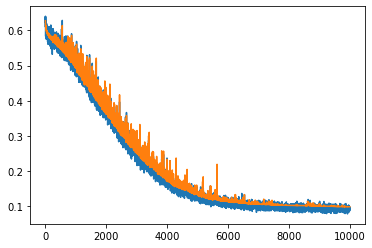

In [134]:

l = min(len(lossi), len(losstesti))
r = [i for i in range(l)]
plt.plot(r, torch.tensor(lossi[:l]), r, torch.tensor(losstesti[:l]))


tensor(0.9907, device='cuda:0')


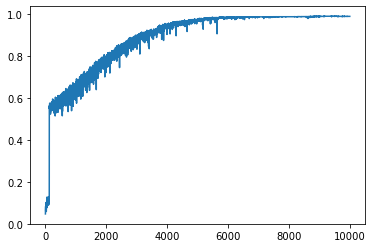

In [135]:

plt.plot(np.array(torch.tensor(acctesti))/X_test.shape[0])
accuracy = acctesti[-1]/X_test.shape[0]
print(accuracy)


In [74]:
import pickle

with open(f"./params{int(accuracy*100000)}.pkl", 'wb') as f:
    pickle.dump(params, f)